In [1]:
import pandas as pd
 
white_wine = pd.read_csv("data/winequality-white.csv", sep=";")
red_wine = pd.read_csv("data/winequality-red.csv", sep=",")

In [2]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0
 
data = pd.concat([red_wine, white_wine], axis=0)
 
# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [6]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


c:\Users\hu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


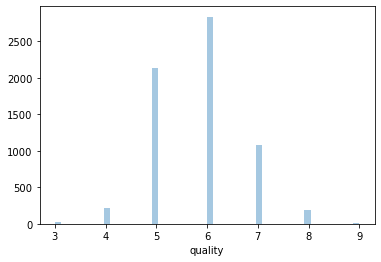

In [7]:
import seaborn as sns
sns.distplot(data.quality, kde=False);

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [8]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

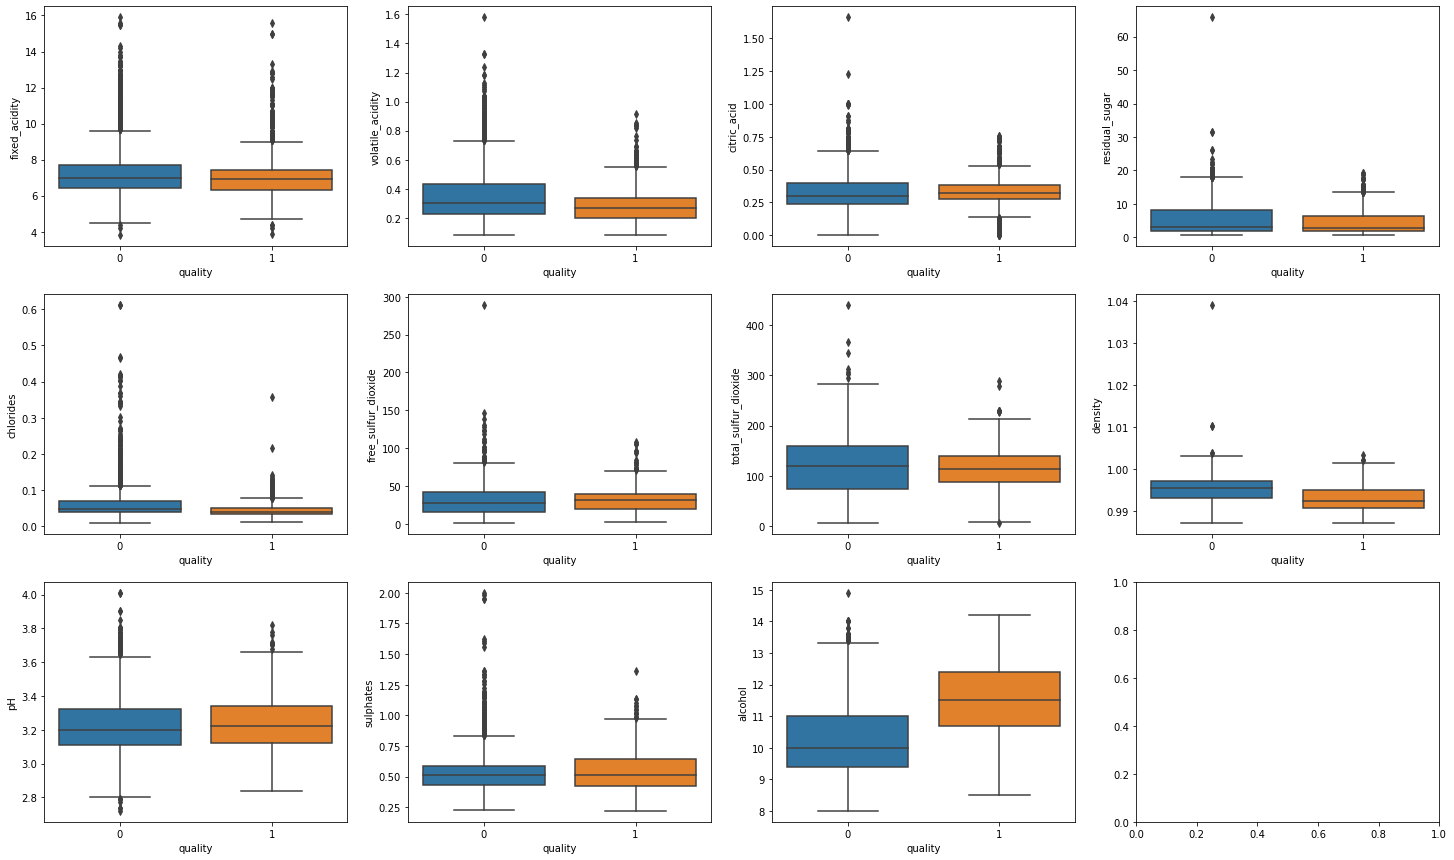

In [12]:
import matplotlib.pyplot as plt
 
dims = (3, 4)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

In [13]:
data.isna().any()


fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

In [14]:
from sklearn.model_selection import train_test_split
 
X = data.drop(["quality"], axis=1)
y = data.quality
 
# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)
 
# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

### Build a baseline model

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

In [15]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time
 
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 
 
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]


# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    # Use the area under the ROC curve as a metric.
    mlflow.log_metric('auc', auc_score)
    wrappedModel = SklearnModelWrapper(model)
    # Log the model with a signature that defines the schema of the model's inputs and outputs. 
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    
    # MLflow contains utilities to create a conda environment used to serve models.
    # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
    conda_env =  _mlflow_conda_env(
            additional_conda_deps=None,
            additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
            additional_conda_channels=None,
        )
    mlflow.pyfunc.log_model("random_forest_model",
                            python_model=wrappedModel,
                            conda_env=conda_env,
                            signature=signature)

c:\Users\hu\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [16]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.160192
density,0.117415
volatile_acidity,0.093136
chlorides,0.086618
residual_sugar,0.082544
free_sulfur_dioxide,0.080473
pH,0.080212
total_sulfur_dioxide,0.077798
sulphates,0.075780
citric_acid,0.071857


As illustrated by the boxplots shown previously, both alcohol and density are important in predicting quality.

You logged the Area Under the ROC Curve (AUC) to MLflow. Click Experiment at the upper right to display the Experiment Runs sidebar.

The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see Receiver Operating Characteristic Curve.

Register the model in MLflow Model Registry
By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI. See "Create or register a model using the UI" (AWS|Azure|GCP).

In [17]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [18]:
run_id

'560257bbcb6246008c4e5384081cae51'

In [20]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'wine_quality'.
Created version '1' of model 'wine_quality'.


In [21]:
"""
The MlflowClient class allows you to interact with the MLflow Tracking Server programmatically. 
You can use it to perform various tasks, such as creating and managing experiments, starting 
and managing runs, logging metrics and parameters, and querying information about experiments and runs.

"""
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

C:\Users\hu\AppData\Local\Temp/ipykernel_16620/3903554456.py:10: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1726979098001, current_stage='Production', description=None, last_updated_timestamp=1726979252071, name='wine_quality', run_id='560257bbcb6246008c4e5384081cae51', run_link=None, source='file:///c:/Users/hu/Desktop/mlop/MLOps/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/mlruns/0/560257bbcb6246008c4e5384081cae51/artifacts/random_forest_model', status='READY', status_message=None, tags={}, user_id=None, version=1>

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

In [22]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
 
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')
AUC: 0.8540300975814177

AUC: 0.8540300975814177


c:\Users\hu\anaconda3\lib\site-packages\mlflow\store\artifact\utils\models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


## Experiment with a new model

The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

In [23]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb
 
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

ModuleNotFoundError: No module named 'hyperopt'


Nested Runs: When you use mlflow.start_run(nested=True) within the main run, you create nested runs. These runs are associated with the main run and inherit some of its parameters and context. Nested runs are typically used to explore variations or sub-experiments within the main experiment.

python
Copy code
import mlflow

with mlflow.start_run():
    # Your main experiment code goes here

    with mlflow.start_run(nested=True):
        # Nested experiment code goes here
Parameters and metrics logged in the nested run are associated with that specific run and can be accessed separately from the main run.
You can create multiple nested runs within a main run to represent different variations or configurations of your experiment.
python
Copy code
import mlflow

with mlflow.start_run():
    # Your main experiment code goes here

    with mlflow.start_run(nested=True):
        # Nested experiment code 1 goes here

    with mlflow.start_run(nested=True):
        # Nested experiment code 2 goes here

In [24]:
def train_model(params):
      # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
    mlflow.xgboost.autolog()
    with mlflow.start_run(nested=True):
        train = xgb.DMatrix(data=X_train, label=y_train)
        validation = xgb.DMatrix(data=X_val, label=y_val)
        # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
        # is no longer improving.
        booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                            evals=[(validation, "validation")], early_stopping_rounds=50)
        validation_predictions = booster.predict(validation)
        auc_score = roc_auc_score(y_val, validation_predictions)
        mlflow.log_metric('auc', auc_score)

        signature = infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, "model", signature=signature)

        # Set the loss to -1*auc_score so fmin maximizes the auc_score
        return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}


In [25]:
import pyspark
from pyspark import SparkContext, SparkConf
conf_spark = SparkConf().set("spark.driver.host", "127.0.0.1")
sc = SparkContext(conf=conf_spark)

ModuleNotFoundError: No module named 'pyspark'

In [ ]:
# !conda remove xgboost -y

In [ ]:
# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials,
  )

In [ ]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

## Update the production wine_quality model in MLflow Model Registry

Earlier, you saved the baseline model to Model Registry with the name wine_quality. Now that you have a created a more accurate model, update wine_quality.



In [ ]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(10)

Click Models in the left sidebar to see that the wine_quality model now has two versions.

The following code promotes the new version to production.

In [ ]:
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage='Archived'
)

client.transition_model_version_stage(
    name=model_name,
    version=new_model_version.version,
    stage='Production'
)

Clients that call load_model now receive the new model.



In [ ]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f"AUC: {roc_auc_score(y_test, model.predict(X_test))}")

## Batch inference

There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

The following code evaluates the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [ ]:
# import mlflow.pyfunc

# apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

In [ ]:
# new_data = spark.read.format("csv").load(table_path) # table_path is path to the delta table

In [ ]:
new_model_version

In [ ]:
new_model_version.run_id

In [ ]:
# Serve the model using the MLflow Model Serving

# Run the following in terminal outiside jupyter and after activating the virtual environment
#mlflow models serve --env-manager=local -m models:/<model_name>/production -h 0.0.0.0 -p 5001

- Here **model_name** is `wine_quality`

In [19]:
mlflow ui


SyntaxError: invalid syntax (Temp/ipykernel_16620/2385425841.py, line 1)

In [ ]:
import requests
import json

url = 'http://localhost:5001/invocations'

datads_dict = {"dataframe_split": X_test.to_dict(orient='split')}

response = requests.post(url, json=datads_dict)
predictions = response.json()

print(predictions)